# Библиотеки

In [ ]:
# Numpy
import numpy as np

# Pandas
import pandas as pd

# Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torch.utils.data as data
from torch.utils.data import DataLoader, TensorDataset, Dataset

# Torchvision
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10, FashionMNIST
from torchvision.utils import make_grid

# Matplotlib и plotly
import matplotlib.pyplot as plt
import plotly.express as px

# cv2
import cv2

# Sklearn
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score, roc_auc_score, accuracy_score
from sklearn.preprocessing import StandardScaler

# OS
import os
import logging
from tqdm.auto import tqdm

import random
from typing import Dict, List, Optional, Tuple

# Вспомогательные функции

In [ ]:
train_dataset = FashionMNIST(root="./", train=True, download=True)
test_dataset = FashionMNIST(root="./", train=False, download=True)

100%|██████████| 26.4M/26.4M [00:02<00:00, 11.6MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 209kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.92MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 12.1MB/s]


In [ ]:
TITLE_FONT_SIZE = 16

def prepare_images(
    train_data: np.ndarray,
    test_data: Optional[np.ndarray] = None,
    dataset_name: str = "CIFAR10"
) -> Tuple[np.ndarray, np.ndarray]:
    if dataset_name == "CIFAR10":
        train_data = np.array([cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in train_data])
        train_data = np.expand_dims(train_data, axis=3)
    train_data = train_data / 255.0
    train_data = np.transpose(train_data, (0, 3, 1, 2))

    if test_data is not None:
        if dataset_name == "CIFAR10":
            test_data = np.array([cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in test_data])
            test_data = np.expand_dims(test_data, axis=3)
        test_data = test_data / 255.0
        test_data = np.transpose(test_data, (0, 3, 1, 2))
        return train_data, test_data

    return train_data

def load_CIFAR10(
    with_targets: bool = False, is_train=True,
) -> Tuple[np.ndarray, Optional[np.ndarray], np.ndarray, Optional[np.ndarray]]:
    dataset = CIFAR10(root="./", train=is_train, download=False)
    data = dataset.data

    if with_targets:
        labels = np.array(dataset.targets)
        return data, labels

    return data

def load_FashionMNIST(
    with_targets: bool = False, is_train=True,
) -> Tuple[np.ndarray, Optional[np.ndarray], np.ndarray, Optional[np.ndarray]]:
    dataset = FashionMNIST(root="./", train=is_train, download=False)

    transform = transforms.Resize((32, 32))
    data = torch.stack([transform(img.unsqueeze(0)) for img in dataset.data]).numpy().transpose(0, 2, 3, 1)

    if with_targets:
        labels = np.array(dataset.targets)
        return data, labels

    return data

def load_dataset(
    is_train: bool = True,
    dataset_name = "CIFAR10",
    classes: Optional[List[int]] = None,
) -> Tuple[np.ndarray, Optional[np.ndarray], np.ndarray, Optional[np.ndarray]]:

    if dataset_name == "CIFAR10":
        data, labels = load_CIFAR10(with_targets=True, is_train=is_train)
    elif dataset_name == "FashionMNIST":
        data, labels = load_FashionMNIST(with_targets=True, is_train=is_train)
    else:
        raise ValueError(f"Unknown dataset name: {dataset_name}")
    data = data.astype("float32")

    data = prepare_images(data, dataset_name=dataset_name)

    if classes is not None:
        mask = np.isin(labels, classes)
        data = data[mask]

    return data

def show_samples(
    samples: np.ndarray,
    title: str,
    figsize: Optional[Tuple[int, int]] = None,
    nrow: Optional[int] = None,
) -> None:
    if isinstance(samples, np.ndarray):
        samples = torch.tensor(samples)
    samples = samples.float()
    if (samples > 1).any():
        samples /= 255
    if nrow is None:
        nrow = int(np.sqrt(len(samples)))
    grid_samples = make_grid(samples, nrow=nrow)

    grid_img = grid_samples.permute(1, 2, 0)
    if figsize is None:
        figsize = (6, 6)

    grid_img = grid_img.clip(0, 1)
    plt.figure(figsize=figsize)
    plt.title(title, fontsize=TITLE_FONT_SIZE)
    plt.imshow(grid_img)
    plt.axis("off")
    plt.show()


def visualize_images(data: np.ndarray, title: str) -> None:
    idxs = np.random.choice(len(data), replace=False, size=(100,))
    images = data[idxs]
    show_samples(images, title)

In [ ]:
from typing import Dict, Optional, Tuple, Union

from matplotlib.axes import Axes
from sklearn.metrics import (
    PrecisionRecallDisplay,
    RocCurveDisplay,
    precision_score,
    recall_score,
    roc_auc_score,
)

def _plot_precision_and_recall_curves(
    y_true: Union[pd.Series, np.ndarray], y_score: Union[pd.Series, np.ndarray], ax: Optional[Axes] = None
) -> None:
    """Метод по отрисовке графиков Precision, Recall и mean_prediction в зависимости от пороговых значений для скора

    Args:
        y_true: фактические метки классов тестовой выборки
        y_score: посчитанные скоры для тестовой выборки
        ax: объект класса Axes для отрисовки графика
    """
    if ax is None:
        _, ax = plt.subplots()

    thresholds = np.linspace(0.01, 0.99, 200)

    precision = []
    recall = []
    proportion = []
    for threshold in thresholds:
        threshold_preds = (y_score > threshold).astype(int)
        precision.append(precision_score(y_true, threshold_preds, zero_division=0))
        recall.append(recall_score(y_true, threshold_preds, zero_division=0))
        proportion.append(threshold_preds.mean())

    ax.plot(thresholds, precision, "-r", label="precision")
    ax.plot(thresholds, recall, "-.b", label="recall")
    ax.plot(thresholds[: len(proportion)], proportion, "--g", label="mean prediction")

    major_ticks = np.arange(0, 1.1, 0.1)
    minor_ticks = np.arange(0.05, 1, 0.1)

    ax.set_xticks(major_ticks)
    ax.set_xticks(minor_ticks, minor=True)
    ax.set_yticks(major_ticks)
    ax.set_yticks(minor_ticks, minor=True)

    ax.grid(which="both", axis="both", visible=True)
    ax.grid(which="minor", alpha=0.2)
    ax.grid(which="major", alpha=0.5)

    ax.set_xlabel("threshold")
    ax.set_ylabel("metrics")
    ax.set_title("Precision and Recall curves")
    ax.legend(
        fontsize=8.5,
        title="",
        frameon=False,
        bbox_to_anchor=(0, -1.15, 1, 1),
        loc="upper center",
        mode="expand",
        ncol=3,
    )

# Модель

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        decoded = decoded.view(x.size(0), 1, 32, 32)
        return decoded

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda


# Семплирование данных

In [ ]:
def sample_data(data: np.ndarray, num_elements: int) -> np.ndarray:
    random_indices = np.random.choice(data.shape[0], num_elements, replace=False)
    return data[random_indices]

def get_data_mix(
    class_1_data: np.ndarray,
    class_3_data: np.ndarray,
    num_samples: int = 2000,
    class3_proportion: float = 0.1,
) -> Tuple[np.ndarray, np.ndarray]:
    num_base_samples = int(num_samples * (1 - class3_proportion))
    num_class3_samples = num_samples - num_base_samples

    train_1_data = sample_data(class_1_data, num_base_samples)
    train_3_data = sample_data(class_3_data, num_class3_samples)

    train_data = np.concatenate([train_1_data, train_3_data])

    return train_data

def get_data_equal(
    class_1_data: np.ndarray,
    class_3_data: np.ndarray,
    num_samples: int = 2000,
) -> Tuple[np.ndarray, np.ndarray]:
    num_class3_samples = class_3_data.shape[0]
    num_base_samples = num_samples - num_class3_samples

    train_1_data = sample_data(class_1_data, num_base_samples)

    train_data = np.concatenate([train_1_data, class_3_data])

    return train_data

def get_data_pair(
    class_1_data: np.ndarray,
    class_2_data: np.ndarray,
    class_3_data: np.ndarray,
    num_samples: int = 2000,
    class3_proportion: float = 0.1,
) -> Tuple[np.ndarray, np.ndarray]:
    num_base_samples = int(num_samples * (1 - class3_proportion))
    num_class3_samples = num_samples - num_base_samples

    train_1_data = sample_data(class_1_data, num_base_samples)
    train_2_data = sample_data(class_2_data, num_base_samples)
    train_3_data = sample_data(class_3_data, num_class3_samples)

    train_1_data = np.concatenate([train_1_data, train_3_data])
    train_2_data = np.concatenate([train_2_data, train_3_data])

    return train_1_data, train_2_data

In [ ]:
def extract_singular_values_from_layer(weight_tensor):
    if len(weight_tensor.shape) == 4:
        out_channels, in_channels, kernel_height, kernel_width = weight_tensor.shape
    else:
        out_channels, in_channels = weight_tensor.shape
    weight_matrix = weight_tensor.reshape(out_channels, -1)

    U, S, Vt = np.linalg.svd(weight_matrix)
    return S

def extract_singular_values_from_encoder(weights):
    singular_values_list = []
    for layer_weights in weights:
        singular_values = extract_singular_values_from_layer(layer_weights)
        singular_values_list.append(singular_values)
    return singular_values_list

def get_vector(model):
    weights = []
    for layer in model.encoder:  # [model.encoder]
        if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
            weights.append(layer.weight.data.cpu().numpy())
    for layer in model.decoder:  # [model.decoder]
        if isinstance(layer, nn.ConvTranspose2d) or isinstance(layer, nn.Linear):
            weights.append(layer.weight.data.cpu().numpy())
    singular_values_list = extract_singular_values_from_encoder(weights)
    return np.concatenate(singular_values_list)

# Обучение

In [ ]:
def train_model(model: Autoencoder, train_loader: DataLoader, num_epochs: int) -> Autoencoder:
    """
    Обучение автоэнкодера

    Args:
        model: модель автоэнкодера
        train_loader: загрузчик данных для обучения
        num_epochs: количество эпох обучения

    Returns:
        Обученная модель
    """
    model.to(DEVICE)
    model.train()
    criterion = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.001)

    for epoch in range(num_epochs):
        for inputs_list in train_loader:
            inputs = inputs_list[0]  # Особенность TensorDataset в DataLoader

            # ============ Forward ============
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            # ============ Backward ============
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    return model

def train_eval_logreg(
    vectors_1: np.array,
    vectors_2: np.array,
    vectors_1_test: np.array,
    vectors_2_test: np.array,
    use_scaler: bool = False,
) -> Tuple[float, float, float]:
    train_size = len(vectors_1)
    test_size = len(vectors_1_test)

    X = np.vstack((vectors_1, vectors_2))
    y = np.array([0] * train_size + [1] * train_size)

    X_shuffled, y_shuffled = shuffle(X, y, random_state=42)

    if use_scaler:
      scaler_lr = StandardScaler()  # Опционально, с ним качество похуже (?)
      X_shuffled = scaler_lr.fit_transform(X_shuffled)

    logreg = LogisticRegression()
    logreg.fit(X_shuffled, y_shuffled)

    X_test = np.vstack((vectors_1_test, vectors_2_test))

    if use_scaler:
        X_test = scaler_lr.transform(X_test)
    y_test = np.array([0] * test_size + [1] * test_size)

    ap = average_precision_score(y_test, logreg.predict_proba(X_test)[:, 1])
    roc_auc = roc_auc_score(y_test, logreg.predict_proba(X_test)[:, 1])
    accuracy = accuracy_score(y_test, logreg.predict(X_test))

    return ap, roc_auc, accuracy

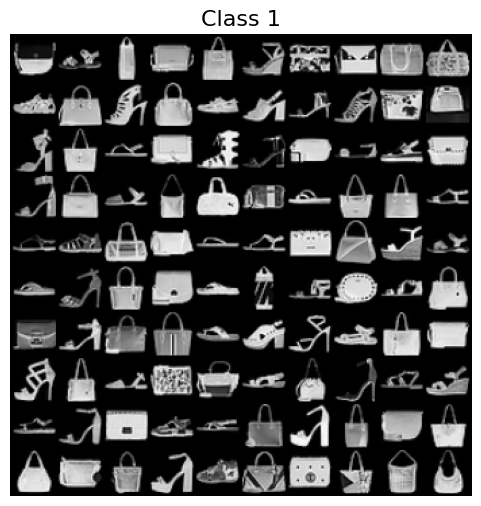

In [ ]:
INPUT_DIM = 1024
HIDDEN_DIM = 256

num_models_train = 100
num_models_test = 100
NUM_EPOCHS = 20
BATCH_SIZE = 32

classes = [5, 6, 8]

USE_SCALER = True
NUM_SAMPLES = 2000

N_RUNS = 5

class_1_data = load_dataset(is_train=True, dataset_name="FashionMNIST", classes=classes[0])
class_2_data = load_dataset(is_train=True, dataset_name="FashionMNIST", classes=classes[1])
class_3_data = load_dataset(is_train=True, dataset_name="FashionMNIST", classes=classes[2])

train_data = get_data_mix(class_1_data, class_3_data, num_samples=2000, class3_proportion=0.5)
# train_data = get_data_equal(class_1_data, sample_data(class_3_data, 1000), num_samples=2000)
# train_data, _ = get_data_pair(class_1_data, class_2_data, class_3_data, num_samples=2000, class3_proportion=0.5)
visualize_images(train_data, "Class 1")

In [ ]:
def train_models(
    num_models: int,
    data_1: np.array,
    data_3: np.array,
    proportion: float,
    mode: str = "train"
) -> List[np.array]:
    """
    Обучение нескольких автоэнкодеров в цикле с сохранением весов и векторов

    Args:
        num_models: количество обучаемых автоэнкодеров
        data_1: выборка основного класса, откуда будет семплирование
        data_3: выборка подмешиваемого класса, откуда будет семплирование
        proportion: доля подмешиваемого класса
        mode: для чего будут использоваться обученные автоэнкодеры, "train" или "test"

    Returns:
        vectors: список векторов закодированных автоэнкодеров
    """
    vectors = []
    for i in range(num_models):
        train_data_np = get_data_mix(data_1, data_3, num_samples=NUM_SAMPLES, class3_proportion=proportion)  # Случайный 3 класс везде
        train_data_tensor = torch.tensor(train_data_np).float().to(DEVICE)  # Для ускорения кладём сразу всю выборку на GPU
        train_dataset_tensor = TensorDataset(train_data_tensor)
        train_loader = DataLoader(train_dataset_tensor, batch_size=BATCH_SIZE, shuffle=True)

        model = Autoencoder(INPUT_DIM, HIDDEN_DIM)
        trained_model = train_model(model, train_loader, NUM_EPOCHS)
        vector = get_vector(trained_model)
        vectors.append(vector)
    return vectors

In [ ]:
table_logger = logging.getLogger('experiment_table')
table_logger.setLevel(logging.INFO)
table_handler = logging.FileHandler('experiment_table_log.txt')
table_handler.setLevel(logging.INFO)
table_logger.addHandler(table_handler)

# Отключаем propagation чтобы сообщения не дублировались в корневом логгере
table_logger.propagate = False

proportion = 0

for class_1 in range(10):
    for class_2 in range(class_1):
        config_name = f"Classes: {class_1} vs {class_2}"
        table_logger.info(f"\n=== Processing configuration: {config_name} ===")

        for run in range(N_RUNS):
            class_1_data = load_dataset(is_train=True, dataset_name="FashionMNIST", classes=class_1)
            class_2_data = load_dataset(is_train=True, dataset_name="FashionMNIST", classes=class_2)
            vectors_1 = train_models(
                num_models_train, class_1_data, class_3_data, proportion
            )
            vectors_2 = train_models(
                num_models_train, class_2_data, class_3_data, proportion
            )

            vectors_1_test = train_models(
                num_models_test, class_1_data, class_3_data, proportion, mode="test"
            )
            vectors_2_test = train_models(
                num_models_test, class_2_data, class_3_data, proportion, mode="test"
            )

            ap, roc_auc, accuracy = train_eval_logreg(
                vectors_1, vectors_2, vectors_1_test, vectors_2_test, use_scaler=USE_SCALER
            )
            table_logger.info(
                f"Run: {run}, Results - AP: {ap}, ROC_AUC: {roc_auc}, Accuracy: {accuracy}"
            )

# Оценка результатов



In [ ]:
import numpy as np
import pandas as pd
import re
import random

# Чтение данных из файла
with open('experiment_table_log.txt', 'r') as file:
    lines = file.readlines()

# Парсинг данных
data = []
for line in lines:
    if 'Classes:' in line:
        # Извлекаем номера классов
        classes = re.findall(r'Classes: (\d+) vs (\d+)', line)[0]
        class1, class2 = map(int, classes)
    elif 'Accuracy:' in line:
        # Извлекаем accuracy
        accuracy = float(re.findall(r'Accuracy: (\d+\.\d+)', line)[0])
        accuracy = round(accuracy, 2)
        data.append((class1, class2, accuracy))

classes = [
    "T-shirt/Top", "Trouser", "Pullover", "Dress", "Coat", "Sandals", "Shirt", "Sneaker", "Bag", "Ankle Boots"
]

# Создаем DataFrame
max_class = max(max(c1, c2) for c1, c2, _ in data) + 1
df = pd.DataFrame(index=classes, columns=classes, dtype=float)

# Заполняем DataFrame
for class1, class2, accuracy in data:
    df.at[classes[class1], classes[class2]] = accuracy

def color_cells(val):
    if pd.isna(val):
        return 'background-color: grey'
    else:
        # Нормализуем значение от 0 до 1 для градиента
        normalized = (val - df.min().min()) / (df.max().max() - df.min().min())
        # Используем градиент от синего (низкие) к красному (высокие)
        red = int(255 * normalized)
        blue = int(255 * (1 - normalized))
        return f'background-color: rgb({red}, 0, {blue})'

styled_df = (
    df.style
    .background_gradient(cmap='YlOrRd', vmin=df.min().min(), vmax=df.max().max()+0.05)
    .highlight_null('#d3d3d3')
)

# Применяем стиль
# styled_df = df.round(2).style.applymap(color_cells)
styled_df.format("{:.2f}", na_rep="NaN")

,T-shirt/Top,Trouser,Pullover,Dress,Coat,Sandals,Shirt,Sneaker,Bag,Ankle Boots
T-shirt/Top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Trouser,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Pullover,0.95,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dress,0.92,1.00,0.94,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Coat,1.00,1.00,0.97,0.92,NaN,NaN,NaN,NaN,NaN,NaN
Sandals,1.00,1.00,1.00,1.00,1.00,NaN,NaN,NaN,NaN,NaN
Shirt,0.76,1.00,0.97,0.93,0.93,0.91,NaN,NaN,NaN,NaN
Sneaker,1.00,1.00,1.00,0.97,1.00,1.00,1.00,NaN,NaN,NaN
Bag,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,NaN,NaN
Ankle Boots,1.00,1.00,1.00,0.91,1.00,1.00,1.00,1.00,1.00,NaN
